In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
            'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
            'annual_inc', 'verification_status', 'purpose', 'dti',
            'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util',
            'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
            'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt',
            'total_rev_hi_lim', 'loan_status_coded']

categorical = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
               'purpose', 'initial_list_status']

Using TensorFlow backend.


In [2]:
# Read in lending club data 
loan_data = pd.read_csv("clean_accepted_loans.csv")


In [5]:
loan_data.loan_status.value_counts()

Current                                                566643
Fully Paid                                             189923
Charged Off                                             40956
Late (31-120 days)                                      10769
Issued                                                   7828
In Grace Period                                          5815
Late (16-30 days)                                        2161
Does not meet the credit policy. Status:Fully Paid       1498
Default                                                  1128
Does not meet the credit policy. Status:Charged Off       562
Name: loan_status, dtype: int64

In [3]:
# Current and Issued loans are still in progress, so they cannot be used for training. Let's split them.

in_progress_index = ['Current', 'Issued']

In [4]:
def split_loan_in_progress(data):
    #"""Return table of loan in progress. It drops the loan in progress from loan data internally."""
    progress_bool = data.loan_status.isin(in_progress_index)
    loan_in_progress = data[progress_bool].drop('loan_status', axis=1)
    data.drop(list(loan_in_progress.index), axis=0, inplace=True)
    return loan_in_progress

In [5]:
loan_in_progress = split_loan_in_progress(loan_data)

print("Shape of loan_in_progress:", loan_in_progress.shape)
print("Shape of loan            :", loan_data.shape)

Shape of loan_in_progress: (574471, 52)
Shape of loan            : (252812, 53)


In [6]:
bad_index = ['Charged Off',
             'Does not meet the credit policy. Status:Charged Off',
             'Default'
             ]

warning_index = ['Late (31-120 days)',
                 'Late (16-30 days)',
                 'In Grace Period'          # (Late (1-15 days)
                 ]

safe_index = ['Fully Paid',
              'Does not meet the credit policy. Status:Fully Paid'
              ]

In [7]:
def categorize_target(data):
    #"""Returns encoded loan status: Safe, Warning and Bad"""

    def func(x):
        if x['loan_status'] in bad_index:
            return 0
        elif x['loan_status'] in warning_index:
            return 1
        else:
            return 2

    data['loan_status_coded'] = data.apply(func, axis=1)
    data.drop('loan_status', axis=1, inplace=True)
    return data

In [8]:
loan_data = categorize_target(loan_data)

In [12]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status_coded
0,0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,...,171.62,NaN,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
1,1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,...,119.66,NaN,Sep-2013,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,...,649.91,NaN,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
4,7,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,...,111.34,NaN,Dec-2014,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
5,8,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,...,152.39,NaN,Aug-2012,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0


In [9]:
def ext_num_from_sub_grade(data):
    data['sub_grade'] = data['sub_grade'].map(lambda x: int(x.lstrip('ABCDEFG')))
    return data

In [10]:
ext_num_from_sub_grade(loan_data)

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status_coded
0,0,1077501,1296599,5000.0,5000.0,4975.000000,36 months,10.65,162.87,B,...,171.62,NaN,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
1,1,1077430,1314167,2500.0,2500.0,2500.000000,60 months,15.27,59.83,C,...,119.66,NaN,Sep-2013,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,2,1077175,1313524,2400.0,2400.0,2400.000000,36 months,15.96,84.33,C,...,649.91,NaN,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
4,7,1072053,1288686,3000.0,3000.0,3000.000000,36 months,18.64,109.43,E,...,111.34,NaN,Dec-2014,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
5,8,1071795,1306957,5600.0,5600.0,5600.000000,60 months,21.28,152.39,F,...,152.39,NaN,Aug-2012,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
6,10,1070078,1305201,6500.0,6500.0,6500.000000,60 months,14.65,153.45,C,...,1655.54,NaN,Dec-2015,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
7,11,1069908,1305008,12000.0,12000.0,12000.000000,36 months,12.69,402.54,B,...,6315.30,NaN,Aug-2013,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
8,12,1064687,1298717,9000.0,9000.0,9000.000000,36 months,13.49,305.38,C,...,305.38,NaN,Nov-2012,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0
9,13,1069866,1304956,3000.0,3000.0,3000.000000,36 months,9.91,96.68,B,...,102.43,NaN,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2
10,15,1069759,1304871,1000.0,1000.0,1000.000000,36 months,16.29,35.31,D,...,36.32,NaN,Jan-2016,0.0,INDIVIDUAL,0.0,NaN,NaN,NaN,2


In [11]:
loan_data.emp_title.isnull().sum()/loan_data.shape[0] * 100

5.437241903074221

In [12]:
#  5% of emp_title feature is filled with null value.
loan_data.emp_title.value_counts().head()

Manager             2076
Teacher             2074
Supervisor           926
Registered Nurse     914
RN                   896
Name: emp_title, dtype: int64

In [13]:
loan_data.emp_title.value_counts()[0]/loan_data.shape[0] * 100

0.82116355236302074

In [14]:
#Although the most frequently answered position is 'Manager', but it accounts for only 0.8% of the entire data. 
#I believe this feature can't represent the whole dataset in meaningful way. So I decided to drop this feature.

def drop_emp_title(data):
    data.drop('emp_title', axis=1, inplace=True)
    return None

In [15]:
drop_emp_title(loan_data)

In [16]:
loan_data.annual_inc.isnull().sum()

#There are only 4 missing values. Let's replace them with median value of feature which is more robust to outlier than mean.

print("Median of annual_inc: ", loan_data.annual_inc.median())
print("Mean of annual_inc:   ", loan_data.annual_inc.mean())

def fill_na_annual_inc(data):
    data.annual_inc.fillna(data.annual_inc.median(), inplace=True)
    return None

fill_na_annual_inc(loan_data)

Median of annual_inc:  62111.5
Mean of annual_inc:    72874.3615451


In [17]:
#As we can see in this graph, it is a time-series data. If we include this columns in our analysis, it expands our model dimension for more than 100. However, performance of model is not greatly affected without this feature. So I decided to exclude this feature in this prediction model.

def drop_issue_d(data):
    data.drop('issue_d', axis=1, inplace=True)
    return None
drop_issue_d(loan_data)

In [18]:
def drop_pymnt_plan(data):
    data.drop('pymnt_plan', axis=1, inplace=True)
    return None
drop_pymnt_plan(loan_data)

In [19]:
def drop_url(data):
    data.drop('url', axis=1, inplace=True)
    return None
drop_url(loan_data)

In [20]:
def fill_na_title(data):
    data.title.fillna('Unknown', inplace=True)
    return None
fill_na_title(loan_data)

In [21]:
def drop_zip_code(data):
    data.drop('zip_code', axis=1, inplace=True)
    return None
drop_zip_code(loan_data)

In [22]:
def drop_addr_state(data):
    data.drop('addr_state', axis=1, inplace=True)
    return None
drop_addr_state(loan_data)

In [23]:
def fill_na_delinq_2yrs(data):
    data.delinq_2yrs.fillna(data.delinq_2yrs.median(), inplace=True)
    return None

fill_na_delinq_2yrs(loan_data)

In [24]:
def drop_earliest_cr_line(data):
    data.drop('earliest_cr_line', axis=1, inplace=True)
    return None
drop_earliest_cr_line(loan_data)

In [25]:
def fill_na_inq_last_6mths(data):
    data.inq_last_6mths.fillna(data.inq_last_6mths.median(), inplace=True)
    return None
fill_na_inq_last_6mths(loan_data)

In [26]:
def fill_na_open_acc(data):
    data.open_acc.fillna(data.open_acc.median(), inplace=True)
    return None
fill_na_open_acc(loan_data)

In [27]:
def fill_na_pub_rec(data):
    data.pub_rec.fillna(data.pub_rec.median(), inplace=True)
    return None
fill_na_pub_rec(loan_data)

In [28]:
def fill_na_revol_util(data):
    data.revol_util.fillna(data.revol_util.median(), inplace=True)
    return None
fill_na_revol_util(loan_data)

In [29]:
def fill_na_total_acc(data):
    data.total_acc.fillna(data.total_acc.median(), inplace=True)
    return None
fill_na_total_acc(loan_data)

In [30]:
def drop_out_prncp(data):
    data.drop('out_prncp', axis=1, inplace=True)
    return None
drop_out_prncp(loan_data)

In [31]:
def drop_out_prncp_inv(data):
    data.drop('out_prncp_inv', axis=1, inplace=True)
    return None
drop_out_prncp_inv(loan_data)

In [32]:
def drop_total_rec_late_fee(data):
    data.drop('total_rec_late_fee', axis=1, inplace=True)
    return None
drop_total_rec_late_fee(loan_data)

In [33]:
def drop_recoveries(data):
    data.drop('recoveries', axis=1, inplace=True)
    return None
drop_recoveries(loan_data)

In [34]:
def drop_collection_recovery_fee(data):
    data.drop('collection_recovery_fee', axis=1, inplace=True)
    return None
drop_collection_recovery_fee(loan_data)

In [35]:
def drop_last_pymnt_d(data):
    data.drop('last_pymnt_d', axis=1, inplace=True)
    return None
drop_last_pymnt_d(loan_data)

In [36]:
def drop_last_credit_pull_d(data):
    data.drop('last_credit_pull_d', axis=1, inplace=True)
    return None
drop_last_credit_pull_d(loan_data)

In [37]:
def drop_collections_12_mths_ex_med(data):
    data.drop('collections_12_mths_ex_med', axis=1, inplace=True)
    return None
drop_collections_12_mths_ex_med(loan_data)

In [38]:
#Again, 99.998% of data are having this value as 'INDIVIDUAL'. Let's drop this column.

def drop_application_type(data):
    data.drop('application_type', axis=1, inplace=True)
    return None
drop_application_type(loan_data)

In [39]:
def drop_acc_now_delinq(data):
    data.drop('acc_now_delinq', axis=1, inplace=True)
    return None
drop_acc_now_delinq(loan_data)

In [40]:
##24% of values are null and 67% are having 0.0 as its value. Let's drop this column.

def drop_tot_coll_amt(data):
    data.drop('tot_coll_amt', axis=1, inplace=True)
    return None
drop_tot_coll_amt(loan_data)

In [41]:
#This column is very ambiguous to deal with. The 24% of the features are null values but it is hard to replace them with mean or median since this feature is widely distributed. I decided not to use this column in prediction.

def drop_tot_cur_bal(data):
    data.drop('tot_cur_bal', axis=1, inplace=True)
    return None
drop_tot_cur_bal(loan_data)

In [42]:
def fill_na_total_rev_hi_lim(data):
    data.total_rev_hi_lim.fillna(data.total_rev_hi_lim.median(), inplace=True)
    return None
fill_na_total_rev_hi_lim(loan_data)

In [43]:
loan_data = loan_data[features]

In [44]:
def one_hot_encoder(loan):
    categorical_variables = categorical
    loan_one_hot_encoded = pd.get_dummies(loan, columns=categorical_variables)
    print("====================[Data Types]====================")
    print(loan_one_hot_encoded.dtypes)
    return loan_one_hot_encoded


In [46]:
loan_one_hot_encoded = one_hot_encoder(loan_data)

====================[Data Types]====================
loan_amnt                              float64
funded_amnt                            float64
funded_amnt_inv                        float64
int_rate                               float64
installment                            float64
sub_grade                                int64
annual_inc                             float64
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
open_acc                               float64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
total_pymnt                            float64
total_pymnt_inv                        float64
total_rec_prncp                        float64
total_rec_int                          float64
last_pymnt_amnt                        float64
total_rev_hi_lim                       float64
loan_st

In [47]:
from sklearn.model_selection import train_test_split

# Train-Test split
y = loan_one_hot_encoded.loan_status_coded
X = loan_one_hot_encoded.drop("loan_status_coded", axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [48]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (202249, 59)
Shape of y_train:  (202249,)
Shape of x_test:  (50563, 59)
Shape of y_test:  (50563,)


In [49]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

def encode_neural_net_y(y):
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    new_y = np_utils.to_categorical(encoded_y)
    return new_y

# Neural Network model
y_train = encode_neural_net_y(y_train)
y_test = encode_neural_net_y(y_test)

In [50]:
y_train

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [51]:
y_test

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization

# create model
model = Sequential()
model.add(Dense(35, input_dim=59, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 35)                2100      
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 108       
Total params: 2,348
Trainable params: 2,278
Non-trainable params: 70
_________________________________________________________________


In [54]:
history = model.fit(np.array(x_train), np.array(y_train), validation_split=0.33,epochs=30, batch_size=40, verbose=1)

Train on 135506 samples, validate on 66743 samples
Epoch 1/30
135506/135506 [==============================] - 26s 192us/step - loss: 0.2189 - acc: 0.9063 - val_loss: 0.1593 - val_acc: 0.9241
Epoch 2/30
135506/135506 [==============================] - 18s 131us/step - loss: 0.1610 - acc: 0.9209 - val_loss: 0.2642 - val_acc: 0.9034
Epoch 3/30
135506/135506 [==============================] - 17s 125us/step - loss: 0.1487 - acc: 0.9229 - val_loss: 0.1602 - val_acc: 0.9239
Epoch 4/30
135506/135506 [==============================] - 17s 123us/step - loss: 0.1426 - acc: 0.9233 - val_loss: 0.1913 - val_acc: 0.9160
Epoch 5/30
135506/135506 [==============================] - 17s 124us/step - loss: 0.1434 - acc: 0.9236 - val_loss: 0.1874 - val_acc: 0.9099
Epoch 6/30
135506/135506 [==============================] - 17s 129us/step - loss: 0.1423 - acc: 0.9241 - val_loss: 0.1324 - val_acc: 0.9291
Epoch 7/30
135506/135506 [==============================] - 17s 127us/step - loss: 0.1388 - acc: 0.9247

In [55]:
scores = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
acc: 92.72%


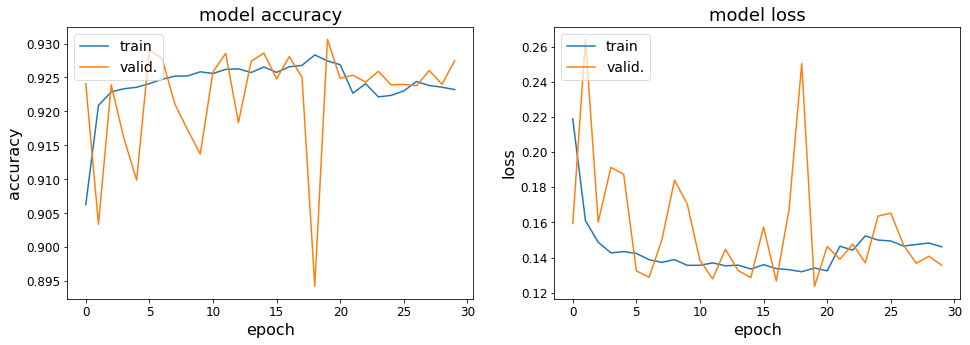

In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

sns.reset_orig()

 #   """Plot accuracy and loss for a Keras history object"""

plt.rcParams["figure.figsize"] = [16, 5]
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['legend.framealpha'] = 0.7
plt.rcParams["legend.fontsize"] = 14

# Plot accuracy

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()


In [58]:
#Performance of maximum classifier will be around 75%

pd.DataFrame(y_test).sum(axis=0)/y_test.shape[0]

0    0.168681
1    0.074145
2    0.757174
dtype: float64

In [59]:
# This model shows great performance on test set. Let's explore the prediction value.

preds = model.predict(np.array(x_test))
preds

array([[  6.76876726e-03,   4.10700589e-03,   9.89124179e-01],
       [  9.70943438e-05,   2.22660179e-04,   9.99680281e-01],
       [  1.20717654e-04,   5.53383470e-05,   9.99823987e-01],
       ..., 
       [  5.38813438e-05,   6.19633065e-05,   9.99884129e-01],
       [  1.80629209e-01,   8.19370747e-01,   2.85671375e-10],
       [  2.42455979e-04,   1.06165404e-04,   9.99651432e-01]], dtype=float32)

In [60]:
preds_class = model.predict_classes(np.array(x_test))
preds_class

array([2, 2, 2, ..., 2, 1, 2], dtype=int64)

In [61]:
y_test

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [62]:
#We can see this model classifies loan in probablistic way.

y_class = pd.DataFrame(y_test).idxmax(axis=1)
y_class.tail()

50558    2
50559    0
50560    2
50561    1
50562    2
dtype: int64

In [63]:
#Distribution of misclassification:

miss_class = y_class[y_class!=preds_class].value_counts()/y_class.shape[0]
miss_class

1    0.05593
0    0.01689
dtype: float64

In [64]:
miss_df = pd.DataFrame(y_class[y_class!=preds_class].value_counts(), columns=['count_miss'])
miss_df

,count_miss
1,2828
0,854


In [65]:
#Mostly, misclassification occured in warning and bad loan set.

In [66]:
from sklearn.metrics import confusion_matrix
cf_mat = confusion_matrix(y_class, preds_class)
cf_mat_p = cf_mat/cf_mat.sum()

In [67]:
cf_mat_p

array([[ 0.15179084,  0.01218282,  0.004707  ],
       [ 0.05286474,  0.0182149 ,  0.00306548],
       [ 0.        ,  0.        ,  0.75717422]])

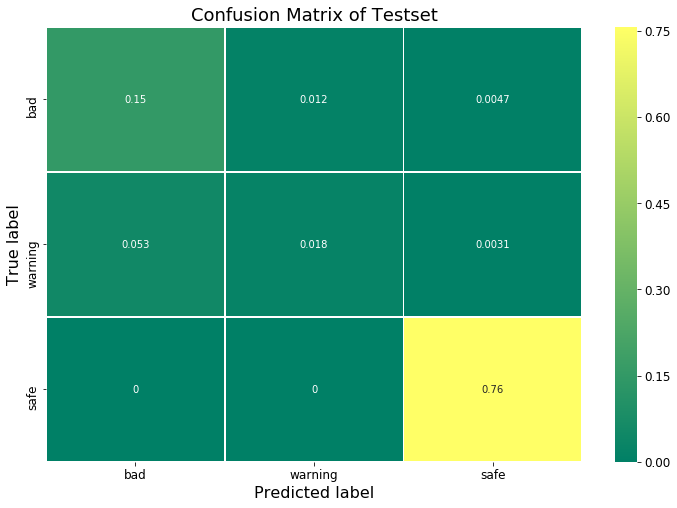

In [68]:
# Plot normalized confusion matrix
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
sns.heatmap(cf_mat_p, annot=True, linewidths=.5, cmap=cm.summer,xticklabels=['bad','warning','safe'], yticklabels=['bad','warning','safe'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix of Testset")
plt.show()

As shown before, this model shows considerably accurate performance. Most of misclassification occurred when it distinguish warning and bad loans. I wondered how this model will perform if it works as a binary classifier without some features.
Let's assume we cannot use grade and sub-grade features, which are rated by Lending Club. And Change our model from multi-class classifier to binary classifier.

In [69]:
# remove 'grade' and 'sub_grade'
features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
            'installment', 'emp_length', 'home_ownership',
            'annual_inc', 'verification_status', 'purpose', 'dti',
            'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util',
            'total_acc', 'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
            'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt',
            'total_rev_hi_lim', 'loan_status_coded']

# remove 'grade'
categorical = ['term', 'emp_length', 'home_ownership', 'verification_status',
               'purpose', 'initial_list_status']

In [70]:
#And let's modify our categorize_target function to be a binary categorizer:

def categorize_target(data):
    #"""Returns encoded loan status: Safe, Warning and Bad"""

    def func(x):
        if x['loan_status'] in bad_index:
            return 0
        elif x['loan_status'] in warning_index:
            return 0
        else:
            return 1

    data['loan_status_coded'] = data.apply(func, axis=1)
    data.drop('loan_status', axis=1, inplace=True)
    return data

In [83]:
def trim_features(loan):
    ext_num_from_sub_grade(loan)
    drop_emp_title(loan)
    fill_na_annual_inc(loan)
    drop_zip_code(loan)
    fill_na_delinq_2yrs(loan)
    drop_earliest_cr_line(loan)
    fill_na_inq_last_6mths(loan)
    fill_na_open_acc(loan)
    fill_na_pub_rec(loan)
    fill_na_revol_util(loan)
    fill_na_total_acc(loan)
    drop_pymnt_plan(loan)
    drop_url(loan)
    drop_total_rec_late_fee(loan)
    drop_out_prncp(loan)
    drop_out_prncp_inv(loan)
    drop_recoveries(loan)
    drop_collection_recovery_fee(loan)
    drop_last_pymnt_d(loan)
    drop_collections_12_mths_ex_med(loan)
    drop_application_type(loan)
    drop_acc_now_delinq(loan)
    drop_tot_coll_amt(loan)
    drop_tot_cur_bal(loan)
    fill_na_total_rev_hi_lim(loan)
    drop_issue_d(loan)
    drop_addr_state(loan)
    drop_last_credit_pull_d(loan)

In [84]:
null_cols = [
             'next_pymnt_d'
            ]


In [85]:
def drop_null_columns(data):
    """Drop columns (most of values are null)"""
    data.drop(null_cols, axis=1, inplace=True)
    return None

In [86]:
# load data
loan = pd.read_csv('clean_accepted_loans.csv')

# pre-process data
drop_null_columns(loan)
loan_in_progress = split_loan_in_progress(loan)
loan = categorize_target(loan)

# Feature Engineering by EDA
trim_features(loan)

# one-hot encoding
loan = loan[features]
loan_one_hot_encoded = one_hot_encoder(loan)

# Train-Test split
y = loan_one_hot_encoded.loan_status_coded
X = loan_one_hot_encoded.drop("loan_status_coded", axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



====================[Data Types]====================
loan_amnt                              float64
funded_amnt                            float64
funded_amnt_inv                        float64
int_rate                               float64
installment                            float64
annual_inc                             float64
dti                                    float64
delinq_2yrs                            float64
inq_last_6mths                         float64
open_acc                               float64
revol_bal                              float64
revol_util                             float64
total_acc                              float64
total_pymnt                            float64
total_pymnt_inv                        float64
total_rec_prncp                        float64
total_rec_int                          float64
last_pymnt_amnt                        float64
total_rev_hi_lim                       float64
loan_status_coded                        int64
term_ 3

In [88]:
model = Sequential()
model.add(Dense(30, input_dim=51, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(np.array(x_train), np.array(y_train), epochs=10, batch_size=40, verbose=1)

Epoch 1/10
202249/202249 [==============================] - 24s 118us/step - loss: 0.0464 - acc: 0.9880
Epoch 2/10
202249/202249 [==============================] - 20s 97us/step - loss: 0.0223 - acc: 0.9947
Epoch 3/10
202249/202249 [==============================] - 18s 90us/step - loss: 0.0281 - acc: 0.9926
Epoch 4/10
202249/202249 [==============================] - 18s 88us/step - loss: 0.0305 - acc: 0.9917
Epoch 5/10
202249/202249 [==============================] - 23s 113us/step - loss: 0.0314 - acc: 0.9917
Epoch 6/10
202249/202249 [==============================] - 25s 123us/step - loss: 0.0265 - acc: 0.9932
Epoch 7/10
202249/202249 [==============================] - 22s 109us/step - loss: 0.0252 - acc: 0.9937
Epoch 8/10
202249/202249 [==============================] - 23s 113us/step - loss: 0.0232 - acc: 0.9944
Epoch 9/10
202249/202249 [==============================] - 22s 111us/step - loss: 0.0229 - acc: 0.9944
Epoch 10/10
202249/202249 [==============================] - 23s 11

In [89]:
##Performance of Binary Classifier (Classifying Good/Bad loans)
scores = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)
print("====================[TEST SCORE]====================")
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

====================[TEST SCORE]====================
acc: 99.67%


This model classifies almost perfectly! Considering the former model, we can guess that this model could miss the classification between 'warning' and 'bad' loans but it almost never misses classifying 'good' versus 'warning' & 'bad' loans. It is commercially acceptible because it suppresses the 'bad' loans to be recognized as 'safe'. ('warning' and 'bad' loans will be underwrited by human underwriter)

In [90]:
bi_preds_class = model.predict_classes(np.array(x_test))
bi_preds_class

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [91]:
y_test.tail()

418505    1
109130    1
80461     1
161298    1
259412    1
Name: loan_status_coded, dtype: int64

In [92]:
miss_class = y_test[y_test!=bi_preds_class].value_counts()/y_test.shape[0]
miss_class

0    0.003145
1    0.000158
Name: loan_status_coded, dtype: float64

In [93]:
from sklearn.metrics import confusion_matrix
cf_mat = confusion_matrix(y_test, bi_preds_class)
cf_mat_p = cf_mat/cf_mat.sum()

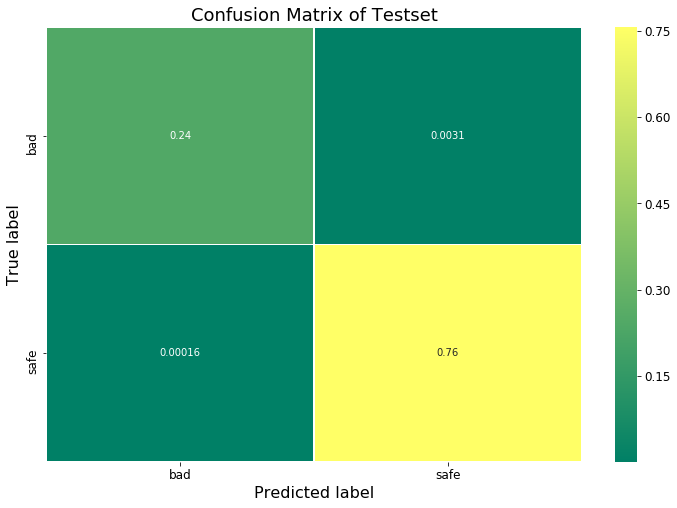

In [94]:
# Plot normalized confusion matrix
import matplotlib.cm as cm
plt.figure(figsize=(12,8))
sns.heatmap(cf_mat_p, annot=True, linewidths=.5, cmap=cm.summer,xticklabels=['bad','safe'], yticklabels=['bad','safe'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix of Testset")
plt.show()